# Apply expected path development to time-series classification
**Data :**
*ItalyPowerDemand* from [UAE](https://www.timeseriesclassification.com/description.php?Dataset=ItalyPowerDemand)


In [1]:
import os
from aeon.datasets import load_from_tsfile
from matplotlib import pyplot as plt

In [2]:
data_dir = os.path.join(os.getcwd(), "..", "data", "ItalyPowerDemand")
train_file = "ItalyPowerDemand_TRAIN.ts"
test_file = "ItalyPowerDemand_TEST.ts"

In [3]:
tsx_train, y_train = load_from_tsfile(os.path.join(data_dir, train_file))
tsx_test, y_test = load_from_tsfile(os.path.join(data_dir, test_file))
y_train = y_train.astype(int)
y_test = y_test.astype(int)

Text(0.5, 0.98, 'Example path from each distribution')

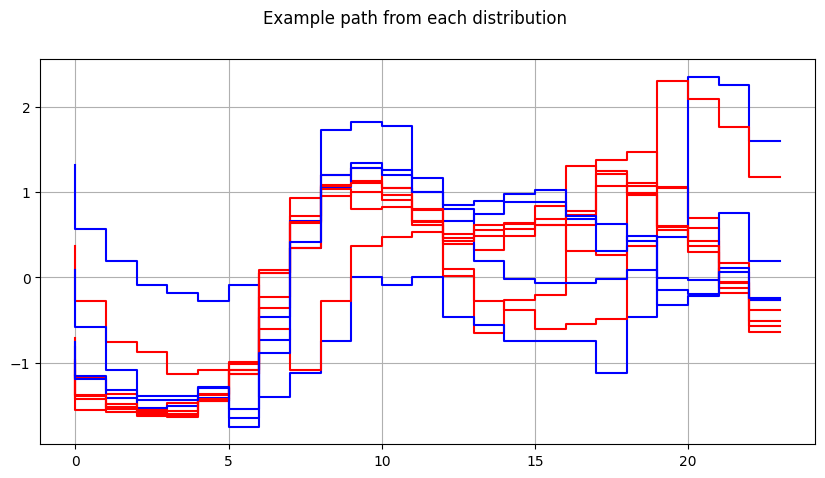

In [4]:
cm = {1: "red", 2: "blue"}
fig, ax = plt.subplots(figsize=(10, 5))
x = range(24)
for i in range(10):
    ax.step(x, tsx_train[i, 0, :], c=cm[y_train[i]])
ax.grid()
fig.suptitle("Example path from each distribution")

## Benchmark
Logistic regression considering tabular data instead of time-series

Number of features = 24

Data is already considered centered and normalised

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [6]:
# train logistic regression
X = tsx_train[:, 0, :]
X_test = tsx_test[:, 0, :]
model = LogisticRegression()
model.fit(X, y_train)
y_hat_train = model.predict(X)
y_hat = model.predict(X_test)
print("Train accuracy : ", np.sum(y_train == y_hat_train) / len(y_train))
print("Test accuracy : ", np.sum(y_test == y_hat) / len(y_test))

Train accuracy :  0.9850746268656716
Test accuracy :  0.9650145772594753


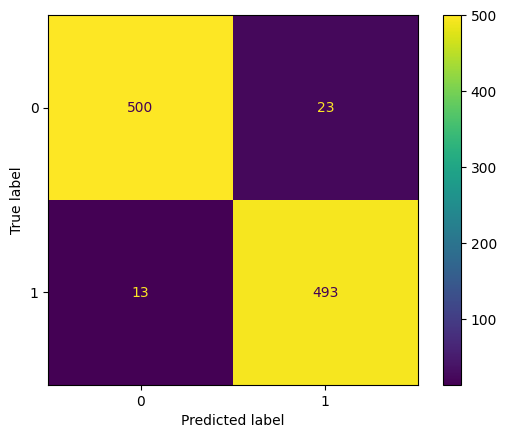

In [7]:
ConfusionMatrixDisplay(confusion_matrix(y_hat, y_test)).plot()

In [8]:
# local imports to compute the development
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

from development.nn import development_layer
from development.so import so

In [9]:
import torch
from torch import optim
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

In [10]:
# time augmentation
tsx_train = np.concatenate(
    [tsx_train, np.repeat(np.array([np.array([list(range(24))])]), len(tsx_train), axis=0)], axis=1
)
tsx_test = np.concatenate(
    [tsx_test, np.repeat(np.array([np.array([list(range(24))])]), len(tsx_test), axis=0)], axis=1
)

# series dimension last
tsx_train = Tensor(tsx_train).swapaxes(1, 2)
tsx_test = Tensor(tsx_test).swapaxes(1, 2)

y_train = Tensor(y_train)
y_test = Tensor(y_test)

## Train expected development 

In [65]:
# build the dataset
batch_size = 35

train = TensorDataset(tsx_train, y_train)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [66]:
def train_model(
    model,
    optimizer,
    data_loader,
    hidden_size: int,
    num_epochs=10,
    alpha=0.5,
    beta=0.2,
    verbose=True,
):
    model.train()
    lossx = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            X = model(inputs)

            Y = X[labels == 1]
            Z = X[labels == 2]

            tau_y = torch.mean(Y, axis=0)
            tau_z = torch.mean(Z, axis=0)
            dtau = tau_y - tau_z
            dtauy = tau_y - Y
            dtauz = tau_z - Z
            loss = (
                -(dtau[0].T.matmul(dtau[0]).diagonal(dim1=0, dim2=1).sum(-1)) / hidden_size
                - beta
                * (dtau[0].T.matmul(dtau[0]).diagonal(dim1=0, dim2=1).sum(-1)) ** 2
                / hidden_size
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauy[:, 0, ...], 1, 2)
                    .bmm(dtauy[:, 0, ...])
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauy)
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauz[:, 0, ...], 1, 2)
                    .bmm(dtauz[:, 0, ...])
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauz)
            )
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        lossx.append(running_loss / len(data_loader))
        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(data_loader)}")

    return lossx

In [67]:
# try diferent sizes and groups and channels

hidden_size = 4
dev_layer = development_layer(
    input_size=2,
    hidden_size=hidden_size,
    channels=1,
    param=so,
    complexification=False,
    return_sequence=False,
)
print(f"Feature space dimension : {int(hidden_size * (hidden_size - 1) / 2)}")

Feature space dimension : 6


Epoch [1/250], Loss: 1.4636319875717163
Epoch [2/250], Loss: 1.2343429625034332
Epoch [3/250], Loss: 1.4516888856887817
Epoch [4/250], Loss: 1.2647503316402435
Epoch [5/250], Loss: 1.33075612783432
Epoch [6/250], Loss: 0.40948575735092163
Epoch [7/250], Loss: 1.341776430606842
Epoch [8/250], Loss: 1.3473315834999084
Epoch [9/250], Loss: 1.3047728538513184
Epoch [10/250], Loss: 1.209682047367096
Epoch [11/250], Loss: 1.144650638103485
Epoch [12/250], Loss: 1.2619554996490479
Epoch [13/250], Loss: 1.2203657627105713
Epoch [14/250], Loss: 1.1293725669384003
Epoch [15/250], Loss: 0.8553025722503662
Epoch [16/250], Loss: 1.1877192854881287
Epoch [17/250], Loss: 1.1291648745536804
Epoch [18/250], Loss: 1.0541871786117554
Epoch [19/250], Loss: 0.7994740903377533
Epoch [20/250], Loss: 0.9285311102867126
Epoch [21/250], Loss: 1.0347661674022675
Epoch [22/250], Loss: 0.918047696352005
Epoch [23/250], Loss: 0.8203178346157074
Epoch [24/250], Loss: 0.8757206499576569
Epoch [25/250], Loss: 0.834286

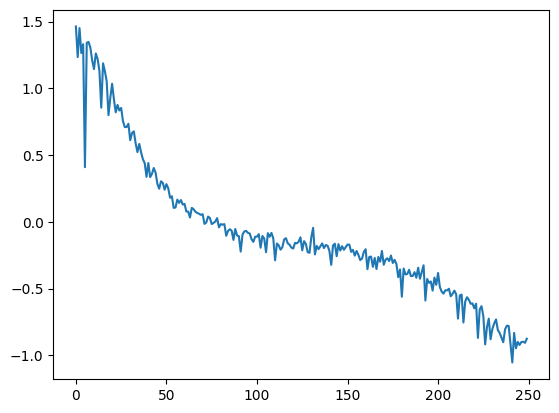

In [68]:
optimizer = optim.Adam(dev_layer.parameters(), lr=0.0008)

lossx = train_model(
    dev_layer, optimizer, train_loader, hidden_size, num_epochs=250, alpha=0.5, beta=0.5
)
_, ax = plt.subplots()
plt.plot(range(len(lossx)), lossx)

## Test expected development 

In [69]:
# Compute the development = feature space
dev_train = dev_layer(tsx_train)
dev_test = dev_layer(tsx_test)
dt1 = dev_train[y_train == 1][:, 0, ...]
dt2 = dev_train[y_train == 2][:, 0, ...]

# expected development = class representative
tau1 = torch.mean(dt1, axis=0)
tau2 = torch.mean(dt2, axis=0)

# Compute the Hilbert-Schmidt distance of train features
diff1 = (dev_train - tau1)[:, 0, ...]
diff2 = (dev_train - tau2)[:, 0, ...]
dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

# predicted labels
c = (dd1 > dd2).detach().numpy().astype(float) + 1

print("Train accuracy : ", (y_train == c).sum().numpy() / len(y_train))

Train accuracy :  0.9701492537313433


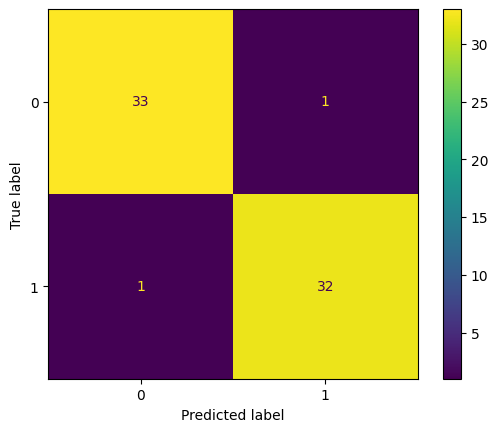

In [70]:
ConfusionMatrixDisplay(confusion_matrix(y_train.numpy(), c)).plot()

In [71]:
# Compute the Hilbert-Schmidt distance of test features
diff1 = (dev_test - tau1)[:, 0, ...]
diff2 = (dev_test - tau2)[:, 0, ...]

dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
print("Test accuracy : ", (y_test.numpy() == c_test).sum() / len(y_test))

Test accuracy :  0.9290573372206026


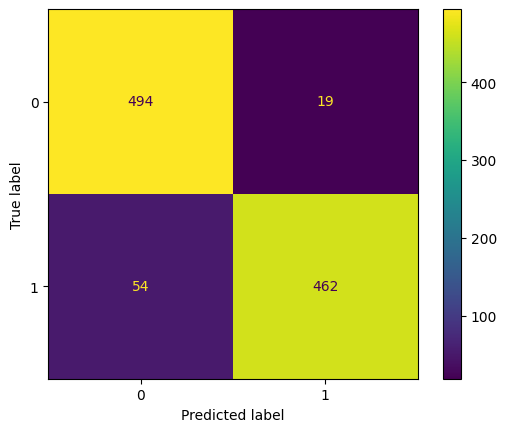

In [72]:
ConfusionMatrixDisplay(confusion_matrix(y_test.numpy(), c_test)).plot()

**Comments :**
With 4 times less dimensions, the expected signature method has the same train accuracy as the logistic regression, but is beaten by 5 points on the test set.

Varying the dimension, group, and number of channels allows to equal / outperform the logistic regression without overfitting during the optimization, provided the train dataset is so small.


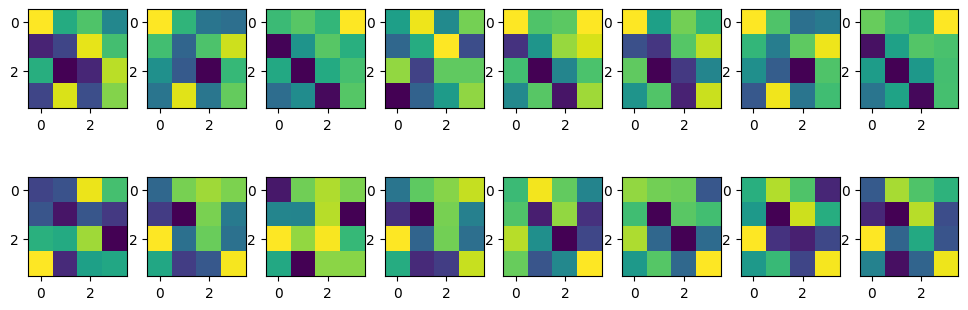

In [22]:
# plot a few examples of development after optimization
_, axs = plt.subplots(nrows=2, ncols=8, figsize=(12, 4))
for i in range(8):
    axs[0, i].imshow(dev_train[y_train == 1][i, 0, ...].detach().numpy())
    axs[1, i].imshow(dev_train[y_train == 2][i, 0, ...].detach().numpy())

In [23]:
torch.save(dev_layer.state_dict(), os.path.join(os.getcwd(), "pdev_ItalyPowerDemand"))

## Compare expected signature

In [24]:
import signatory

In [25]:
depth = 2
sig_train = signatory.signature(tsx_train, depth=depth)

# the embedding is parameter-free
esig1 = torch.mean(sig_train[y_train == 1], axis=0)
esig2 = torch.mean(sig_train[y_train == 2], axis=0)

In [26]:
print("Number of features : ", len(esig1))

Number of features :  6


In [27]:
def tensor_inner_product_level(t1k: Tensor, t2k: Tensor, n: int, k: int, d: int) -> Tensor:
    t1k = t1k.reshape((n, d, 2 ** (k - 1)))
    t2k = t2k.reshape((n, d, 2 ** (k - 1)))
    return (t1k * t2k).sum(dim=1).prod(dim=1)


def batched_tensor_inner_product(t1: Tensor, t2: Tensor, d: int, depth: int) -> Tensor:
    batch_size = t1.size(0)
    assert t1.size(0) == t2.size(0)
    p = torch.zeros(batch_size)
    for k in range(1, depth):
        t1k = signatory.extract_signature_term(t1, d, k)
        t2k = signatory.extract_signature_term(t2, d, k)
        p += tensor_inner_product_level(t1k, t2k, batch_size, k, d)
    return p

In [28]:
dsig1 = sig_train - esig1
dsig2 = sig_train - esig2

ddsig1 = batched_tensor_inner_product(dsig1, dsig1, 2, depth)
ddsig2 = batched_tensor_inner_product(dsig2, dsig2, 2, depth)

c = (ddsig1 > ddsig2).detach().numpy().astype(float) + 1
print("Train accuracy : ", (y_train == c).sum().numpy() / len(y_train))

Train accuracy :  0.5522388059701493


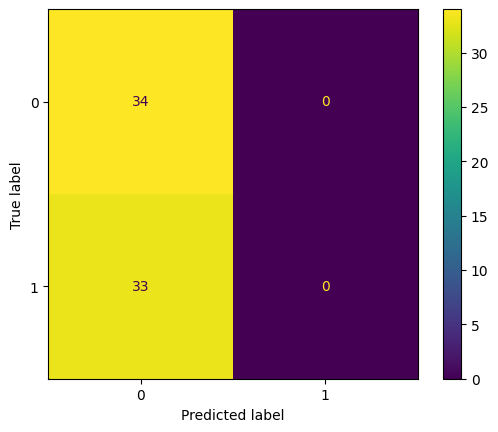

In [32]:
ConfusionMatrixDisplay(confusion_matrix(y_train, c)).plot()

In [33]:
accuracyx = []
for depth in range(2, 10):
    sig_train = signatory.signature(tsx_train, depth=depth)

    # the embedding is parameter-free
    esig1 = torch.mean(sig_train[y_train == 1], axis=0)
    esig2 = torch.mean(sig_train[y_train == 2], axis=0)
    dsig1 = sig_train - esig1
    dsig2 = sig_train - esig2

    ddsig1 = batched_tensor_inner_product(dsig1, dsig1, 2, depth)
    ddsig2 = batched_tensor_inner_product(dsig2, dsig2, 2, depth)

    c = (ddsig1 > ddsig2).detach().numpy().astype(float) + 1
    accuracyx.append((y_train == c).sum().numpy() / len(y_train))

Text(0.5, 1.0, 'Influence of the depth of the signature')

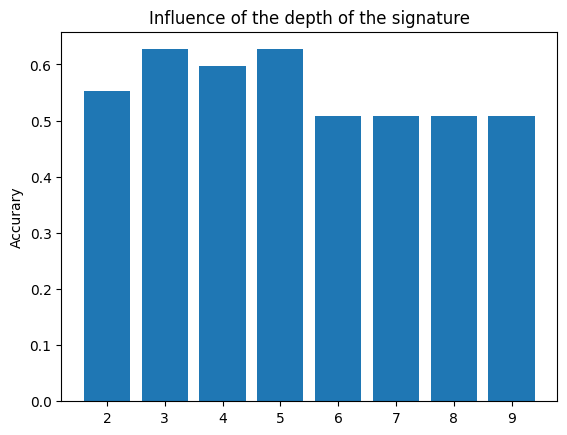

In [38]:
_, ax = plt.subplots()
ax.bar(range(2, 10), accuracyx)
ax.set_ylabel("Accurary")
ax.set_title("Influence of the depth of the signature")

## Influence of the hidden size

In [41]:
# try diferent sizes and groups and channels
hx = range(2, 11)
res = pd.DataFrame(index=hx, columns=["Train", "Test"])

for h in hx:
    print("\n")
    print("#####################################")
    print(f">>> Hidden size = {h}")
    print("#####################################")
    dev_layer = development_layer(
        input_size=2,
        hidden_size=h,
        channels=1,
        param=so,
        complexification=False,
        return_sequence=False,
    )
    optimizer = optim.Adam(dev_layer.parameters(), lr=0.001)
    lossx = train_model(dev_layer, optimizer, train_loader, h, num_epochs=300, verbose=False)
    # _, ax = plt.subplots()
    # ax.plot(range(len(lossx)), lossx)
    # ax.set_title(f"Loss hidden_size={h}")
    # ax.set_xlabel("n epoch")
    # ax.legend()
    # ax.grid()

    dev_train = dev_layer(tsx_train)
    dev_test = dev_layer(tsx_test)

    dt1 = dev_train[y_train == 1][:, 0, ...]
    dt2 = dev_train[y_train == 2][:, 0, ...]

    tau1 = torch.mean(dt1, axis=0)
    tau2 = torch.mean(dt2, axis=0)

    # train
    diff1 = (dev_train - tau1)[:, 0, ...]
    diff2 = (dev_train - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c = (dd1 > dd2).detach().numpy().astype(float) + 1

    # ConfusionMatrixDisplay(confusion_matrix(y_train.numpy(), c)).plot()
    actrain = (y_train == c).sum().numpy() / len(y_train)
    print(h, f"Train accuracy={actrain}")

    # test
    diff1 = (dev_test - tau1)[:, 0, ...]
    diff2 = (dev_test - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
    actest = (y_test.numpy() == c_test).sum() / len(y_test)
    res.loc[h] = [actrain, actest]
    print(h, f"Test accuracy={actest}")

    # ConfusionMatrixDisplay(
    #     confusion_matrix(y_test.numpy(), c_test)
    # ).plot()



#####################################
>>> Hidden size = 2
#####################################
2 Train accuracy=0.5373134328358209
2 Test accuracy=0.5617103984450923


#####################################
>>> Hidden size = 3
#####################################
3 Train accuracy=0.9850746268656716
3 Test accuracy=0.9475218658892128


#####################################
>>> Hidden size = 4
#####################################
4 Train accuracy=0.9850746268656716
4 Test accuracy=0.9543245869776482


#####################################
>>> Hidden size = 5
#####################################
5 Train accuracy=0.9850746268656716
5 Test accuracy=0.9582118561710399


#####################################
>>> Hidden size = 6
#####################################
6 Train accuracy=0.9850746268656716
6 Test accuracy=0.9601554907677357


#####################################
>>> Hidden size = 7
#####################################
7 Train accuracy=0.9701492537313433
7 Test accuracy=0.956

In [42]:
res.astype(float).round(3) * 100

,Train,Test
2,53.7,56.2
3,98.5,94.8
4,98.5,95.4
5,98.5,95.8
6,98.5,96.0
7,97.0,95.6
8,97.0,95.0
9,97.0,95.3
10,97.0,95.1


**Comments :**
A sufficient size allows more expressiveness, at the cost of a more sensitive optimization procedure, hence the accuracy is not increasing significantly for dimensions higher than 6.

## Influence of the group

In [43]:
from development.se import se
from development.sp import sp

In [44]:
# try diferent sizes and groups and channels
paramx = [so, sp, se]
hidden_size = 6
res = pd.DataFrame(index=[p.__name__ for p in paramx], columns=["Train", "Test"])

for param in paramx:
    print("\n")
    print("#####################################")
    print(f">>> Param = {param.__name__}")
    print("#####################################")
    dev_layer = development_layer(
        input_size=2,
        hidden_size=hidden_size,
        channels=1,
        param=param,
        complexification=False,
        return_sequence=False,
    )
    optimizer = optim.Adam(dev_layer.parameters(), lr=0.001)
    lossx = train_model(
        dev_layer, optimizer, train_loader, hidden_size, num_epochs=300, verbose=False
    )

    dev_train = dev_layer(tsx_train)
    dev_test = dev_layer(tsx_test)

    dt1 = dev_train[y_train == 1][:, 0, ...]
    dt2 = dev_train[y_train == 2][:, 0, ...]

    tau1 = torch.mean(dt1, axis=0)
    tau2 = torch.mean(dt2, axis=0)

    # # train
    diff1 = (dev_train - tau1)[:, 0, ...]
    diff2 = (dev_train - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c = (dd1 > dd2).detach().numpy().astype(float) + 1

    actrain = (y_train == c).sum().numpy() / len(y_train)
    print(param.__name__, f"Train accuracy={actrain}")

    # test
    diff1 = (dev_test - tau1)[:, 0, ...]
    diff2 = (dev_test - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
    actest = (y_test.numpy() == c_test).sum() / len(y_test)
    res.loc[param.__name__] = [actrain, actest]
    print(param.__name__, f"Test accuracy={actest}")



#####################################
>>> Param = so
#####################################
so Train accuracy=0.9850746268656716
so Test accuracy=0.9465500485908649


#####################################
>>> Param = sp
#####################################
sp Train accuracy=0.7313432835820896
sp Test accuracy=0.6822157434402333


#####################################
>>> Param = se
#####################################
se Train accuracy=0.9850746268656716
se Test accuracy=0.924198250728863


In [45]:
res.astype(float).round(3) * 100

,Train,Test
so,98.5,94.7
sp,73.1,68.2
se,98.5,92.4


## Influence of the number of channels

In [54]:
def train_model_multichannels(
    model,
    optimizer,
    data_loader,
    hidden_size: int,
    num_epochs=10,
    alpha=0.5,
    beta=0.2,
    verbose=True,
):
    model.train()
    lossx = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            X = model(inputs)

            Y = X[labels == 1]
            Z = X[labels == 2]

            tau_y = torch.mean(Y, axis=0)
            tau_z = torch.mean(Z, axis=0)
            dtau = tau_y - tau_z
            dtauy = tau_y - Y
            dtauz = tau_z - Z
            b, c, d, _ = X.shape

            loss = (
                -(1 - beta)
                * (torch.swapaxes(dtau, 1, 2).bmm(dtau).diagonal(dim1=1, dim2=2).sum())
                / hidden_size
                / b
                - beta
                * (torch.swapaxes(dtau, 1, 2).bmm(dtau).diagonal(dim1=1, dim2=2).sum()) ** 2
                / hidden_size
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauy.reshape((len(dtauy) * c, d, d)), 1, 2)
                    .bmm(dtauy.reshape((len(dtauy) * c, d, d)))
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauy)
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauz.reshape((len(dtauz) * c, d, d)), 1, 2)
                    .bmm(dtauz.reshape((len(dtauz) * c, d, d)))
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauz)
            ) / c
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        lossx.append(running_loss / len(data_loader))
        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(data_loader)}")

    return lossx

In [47]:
# build the dataset
batch_size = 34
train = TensorDataset(tsx_train, y_train)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [48]:
hidden_size = 5
nchannels = 2
dev_layer = development_layer(
    input_size=2,
    hidden_size=hidden_size,
    channels=nchannels,
    param=so,
    complexification=False,
    return_sequence=False,
)

Epoch [1/200], Loss: 0.072042316198349
Epoch [2/200], Loss: 0.08645493537187576
Epoch [3/200], Loss: 0.10043995082378387
Epoch [4/200], Loss: -0.028511017560958862
Epoch [5/200], Loss: 0.005424782633781433
Epoch [6/200], Loss: -0.01673838496208191
Epoch [7/200], Loss: 0.03158023953437805
Epoch [8/200], Loss: -0.08334453403949738
Epoch [9/200], Loss: -0.053044259548187256
Epoch [10/200], Loss: -0.05521414428949356
Epoch [11/200], Loss: -0.14156901836395264
Epoch [12/200], Loss: -0.26879917085170746
Epoch [13/200], Loss: -0.2764441967010498
Epoch [14/200], Loss: -0.45258955657482147
Epoch [15/200], Loss: -0.41086603701114655
Epoch [16/200], Loss: -0.32577553391456604
Epoch [17/200], Loss: -0.44176071882247925
Epoch [18/200], Loss: -0.4307772368192673
Epoch [19/200], Loss: -0.5224354863166809
Epoch [20/200], Loss: -0.4878537207841873
Epoch [21/200], Loss: -0.4781450778245926
Epoch [22/200], Loss: -0.5591484606266022
Epoch [23/200], Loss: -0.5731928199529648
Epoch [24/200], Loss: -0.584909

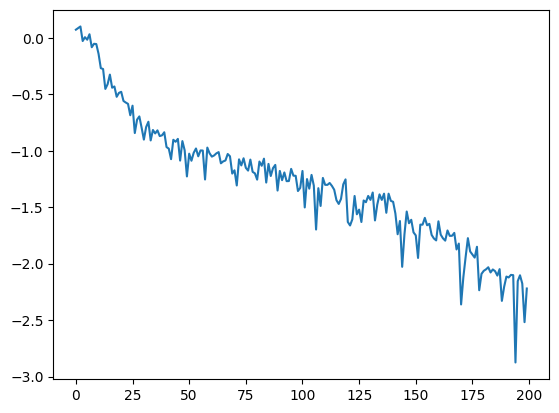

In [49]:
optimizer = optim.Adam(dev_layer.parameters(), lr=0.0005)

lossx = train_model_multichannels(
    dev_layer, optimizer, train_loader, hidden_size, num_epochs=200, alpha=0.5, beta=0.5
)
_, ax = plt.subplots()
plt.plot(range(len(lossx)), lossx)

In [50]:
dev_train = dev_layer(tsx_train)
dev_test = dev_layer(tsx_test)
dt1 = dev_train[y_train == 1]
dt2 = dev_train[y_train == 2]
tau1 = torch.mean(dt1, axis=0)
tau2 = torch.mean(dt2, axis=0)

diff1 = (dev_train - tau1).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff2 = (dev_train - tau2).reshape((len(y_train) * nchannels, hidden_size, hidden_size))

dd1 = (
    torch.swapaxes(diff1, 1, 2)
    .bmm(diff1)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd2 = (
    torch.swapaxes(diff2, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)

c = (dd1 > dd2).detach().numpy().astype(float) + 1
print("train accuracy : ", (y_train == c).sum().numpy() / len(y_train))

diff1 = (dev_test - tau1).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff2 = (dev_test - tau2).reshape((len(y_test) * nchannels, hidden_size, hidden_size))

dd1 = (
    torch.swapaxes(diff1, 1, 2)
    .bmm(diff1)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd2 = (
    torch.swapaxes(diff2, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)

c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
print("test accuracy : ", (y_test.numpy() == c_test).sum() / len(y_test))

train accuracy :  0.9850746268656716
test accuracy :  0.967930029154519


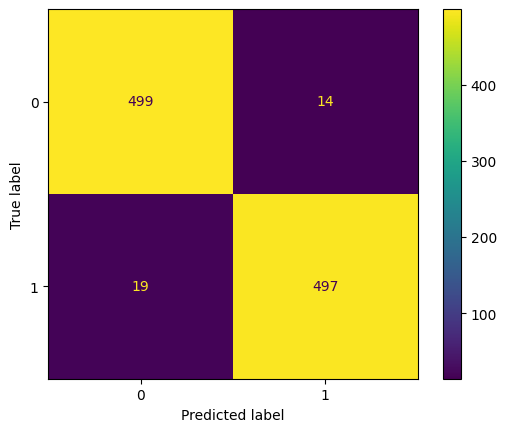

In [51]:
ConfusionMatrixDisplay(confusion_matrix(y_test.numpy(), c_test)).plot()

**Comments :**
This outperforms the logistic regression by half a point of accuracy.
It strongly relies on the quality of the optimisation and there is no intrinsic rule to choose the dimension and number of channels a priori.

In [52]:
# try diferent sizes and groups and channels
hidden_size = 5
nchannelsx = range(1, 6)
res = pd.DataFrame(index=nchannelsx, columns=["Train", "Test"])
for nchannels in nchannelsx:
    print("\n")
    print("#####################################")
    print(f">>> n channels = {nchannels}")
    print("#####################################")
    dev_layer = development_layer(
        input_size=2,
        hidden_size=hidden_size,
        channels=nchannels,
        param=so,
        complexification=False,
        return_sequence=False,
    )
    optimizer = optim.Adam(dev_layer.parameters(), lr=0.0005)
    lossx = train_model_multichannels(
        dev_layer,
        optimizer,
        train_loader,
        hidden_size,
        num_epochs=220,
        verbose=False,
        alpha=0.5,
        beta=0.5,
    )

    dev_train = dev_layer(tsx_train)
    dev_test = dev_layer(tsx_test)
    dt1 = dev_train[y_train == 1]
    dt2 = dev_train[y_train == 2]
    tau1 = torch.mean(dt1, axis=0)
    tau2 = torch.mean(dt2, axis=0)
    ddt1 = dt1 - tau1
    ddt2 = dt2 - tau2
    diff1 = (dev_train - tau1).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
    diff2 = (dev_train - tau2).reshape((len(y_train) * nchannels, hidden_size, hidden_size))

    dd1 = (
        torch.swapaxes(diff1, 1, 2)
        .bmm(diff1)
        .reshape((len(y_train), nchannels, hidden_size, hidden_size))
        .diagonal(dim1=2, dim2=3)
        .sum(-1)
        .sum(-1)
    )
    dd2 = (
        torch.swapaxes(diff2, 1, 2)
        .bmm(diff2)
        .reshape((len(y_train), nchannels, hidden_size, hidden_size))
        .diagonal(dim1=2, dim2=3)
        .sum(-1)
        .sum(-1)
    )

    c = (dd1 > dd2).detach().numpy().astype(float) + 1
    actrain = (y_train == c).sum().numpy() / len(y_train)

    print(nchannels, "train accuracy : ", actrain)

    diff1 = (dev_test - tau1).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
    diff2 = (dev_test - tau2).reshape((len(y_test) * nchannels, hidden_size, hidden_size))

    dd1 = (
        torch.swapaxes(diff1, 1, 2)
        .bmm(diff1)
        .reshape((len(y_test), nchannels, hidden_size, hidden_size))
        .diagonal(dim1=2, dim2=3)
        .sum(-1)
        .sum(-1)
    )
    dd2 = (
        torch.swapaxes(diff2, 1, 2)
        .bmm(diff2)
        .reshape((len(y_test), nchannels, hidden_size, hidden_size))
        .diagonal(dim1=2, dim2=3)
        .sum(-1)
        .sum(-1)
    )

    c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
    actest = (y_test.numpy() == c_test).sum() / len(y_test)
    print(nchannels, "test accuracy : ", actest)

    res.loc[nchannels] = [actrain, actest]



#####################################
>>> n channels = 1
#####################################
1 train accuracy :  0.9701492537313433
1 test accuracy :  0.9708454810495627


#####################################
>>> n channels = 2
#####################################
2 train accuracy :  0.9850746268656716
2 test accuracy :  0.9620991253644315


#####################################
>>> n channels = 3
#####################################
3 train accuracy :  0.9701492537313433
3 test accuracy :  0.9533527696793003


#####################################
>>> n channels = 4
#####################################
4 train accuracy :  0.9701492537313433
4 test accuracy :  0.956268221574344


#####################################
>>> n channels = 5
#####################################
5 train accuracy :  0.9701492537313433
5 test accuracy :  0.9611273080660836


In [53]:
res.astype(float).round(3) * 100

,Train,Test
1,97.0,97.1
2,98.5,96.2
3,97.0,95.3
4,97.0,95.6
5,97.0,96.1
